In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

from transformer.encoder import Encoder
from transformer.utils import WordTokenizer

In [2]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': (100,),
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [3]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
df['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [5]:
tokenizer = WordTokenizer(make_mask=True)
config['vocab_size'] = tokenizer.fit(df['sentence'].values)
X, masks = tokenizer.transform(df['sentence'].values, max_len=config['input_size'][0])
y = df['sentiment'].values

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')

Number of sentences: 1000
Vocabulary size: 2971


## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [25]:
encoder_model = tf.keras.models.load_model('encoder_model.h5', 
                                           custom_objects={'Encoder': Encoder})

input1, input2 = encoder_model.input
x = encoder_model([input1, input2])
output = Dense(1, activation='sigmoid')(x)

clf = Model(inputs=encoder_model.input,
            outputs=output)

# #clf.layers[0].trainable=False
clf.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model_2 (Functional)           (None, 128)          640232      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_627 (Dense)              (None, 1)            129         ['model_2[0][0]']          

In [26]:
clf.compile(optimizer=Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])
hist = clf.fit([X, masks],
               y,
               epochs=20)

Epoch 1/20
32/32 [==============================] - 20s 145ms/step - loss: 1.3761 - accuracy: 0.5050
Epoch 2/20
32/32 [==============================] - 5s 147ms/step - loss: 0.6803 - accuracy: 0.5580
Epoch 3/20
32/32 [==============================] - 5s 146ms/step - loss: 0.5756 - accuracy: 0.7010
Epoch 4/20
32/32 [==============================] - 5s 144ms/step - loss: 0.3684 - accuracy: 0.8480
Epoch 5/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1854 - accuracy: 0.9190
Epoch 6/20
32/32 [==============================] - 5s 145ms/step - loss: 0.1112 - accuracy: 0.9600
Epoch 7/20
32/32 [==============================] - 5s 146ms/step - loss: 0.0745 - accuracy: 0.9700
Epoch 8/20
32/32 [==============================] - 5s 145ms/step - loss: 0.0411 - accuracy: 0.9880
Epoch 9/20
32/32 [==============================] - 5s 150ms/step - loss: 0.0505 - accuracy: 0.9880
Epoch 10/20
32/32 [==============================] - 5s 145ms/step - loss: 0.0145 - accuracy: 0.994

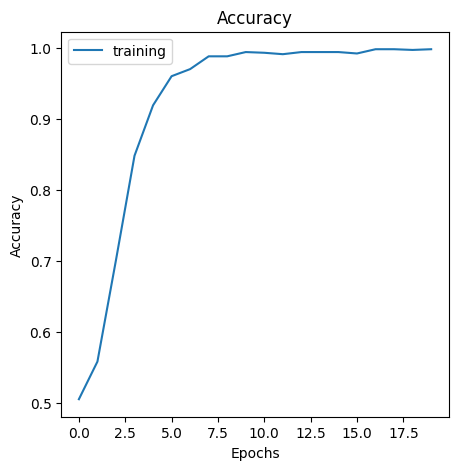

In [27]:
plt.figure(figsize=(5,5))
plt.plot(hist.history['accuracy'], label='training')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Test with new made up sentences

In [31]:
s = ["It really tasted awful.",
     "It was very good.",
     "It was awful.",
     "This is a very bad restaurant.",
     "The spaghetti was perfect",
     "The eggs were gross!",
     "My steak was bad.",
     "I love this place and will be back soon!",
     "The service was great, and the food was great.",
     "The worst steak I have eaten."]

y = [0, 1, 0, 0, 1, 0, 0, 1, 1, 0]

sentiments = ['negative', 'positive']

# Tokenize our sentence, separate last word, and pad
X_test, masks_test = tokenizer.transform(s, max_len=config['input_size'][0])

# predict sentiment
y_hat = clf.predict([X_test, masks_test])
y_hat = (y_hat >= 0.5).astype(int)
accuracy = accuracy_score(y, y_hat)
print(f'Accuracy {accuracy * 100: .2f}%\n')

results = []
for i in range(len(s)):
     # construct predicted complete sentence
     results.append({'Sentence': s[i], 
                     'Predicted Sentiment': sentiments[y_hat[i][0]],
                     'Actual Sentiment': sentiments[y[i]]})

pd.DataFrame(results)

1/1 [==============================] - 2s 2s/step
Accuracy  100.00%



,Sentence,Predicted Sentiment,Actual Sentiment
0,It really tasted awful.,negative,negative
1,It was very good.,positive,positive
2,It was awful.,negative,negative
3,This is a very bad restaurant.,negative,negative
4,The spaghetti was perfect,positive,positive
5,The eggs were gross!,negative,negative
6,My steak was bad.,negative,negative
7,I love this place and will be back soon!,positive,positive
8,"The service was great, and the food was great.",positive,positive
9,The worst steak I have eaten.,negative,negative
